In [1]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 21.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import control as ct
from scipy.integrate import solve_ivp

In [3]:
#@title Construindo o modelo
# Definir os parâmetros
cv, a = [[0.1,0.5],[2.0,4.0]]
# Estados
t = sp.Symbol('t')
h1 = sp.Function('h1')(t)
h2 = sp.Function('h2')(t)
X = sp.Matrix([h1, h2])
# Entradas
q1 = sp.Function('q1')(t)
q2 = sp.Function('q2')(t)
U = sp.Matrix([q1,q2])
# EDOS
edos = sp.Matrix([(q1 - cv[0]*sp.sqrt(h1-h2))/a[0],
                  (q2 + cv[0]*sp.sqrt(h1-h2) - cv[1]*sp.sqrt(h2))/a[1]])
edos

Matrix([
[                     -0.05*sqrt(h1(t) - h2(t)) + 0.5*q1(t)],
[0.025*sqrt(h1(t) - h2(t)) - 0.125*sqrt(h2(t)) + 0.25*q2(t)]])

In [4]:
#@title Calculo do estacionário
# Dado essas vazões de entrada, quais os valores de h1 e h2
qss = [0.5,2.0]
sol_ss = sp.solve(edos.subs([(q1,qss[0]),(q2,qss[1])]),X)
hss = [float(sol_ss[0][0]),float(sol_ss[0][1])]
print(f'Para qss = {qss}')
print(f'hss = {hss}')

Para qss = [0.5, 2.0]
hss = [50.0, 25.0]


In [5]:
#@title Linearização
A = edos.jacobian(X).subs([(q1,qss[0]),(q2,qss[1]),(h1,hss[0]),(h2,hss[1])])
Anum = np.array(A, dtype=float)
B = edos.jacobian(U).subs([(q1,qss[0]),(q2,qss[1]),(h1,hss[0]),(h2,hss[1])])
Bnum = np.array(B, dtype=float)

In [6]:
Anum

array([[-0.005 ,  0.005 ],
       [ 0.0025, -0.015 ]])

In [7]:
#@title Estabilidade
auto_valor = np.linalg.eigvals(Anum)
print(auto_valor)

[-0.00387628 -0.01612372]


In [8]:
# Verificar estabilidade
if all(auto_valor < 0):
    print("Sistema ESTÁVEL")
else:
    print("Sistema INSTÁVEL")

Sistema ESTÁVEL


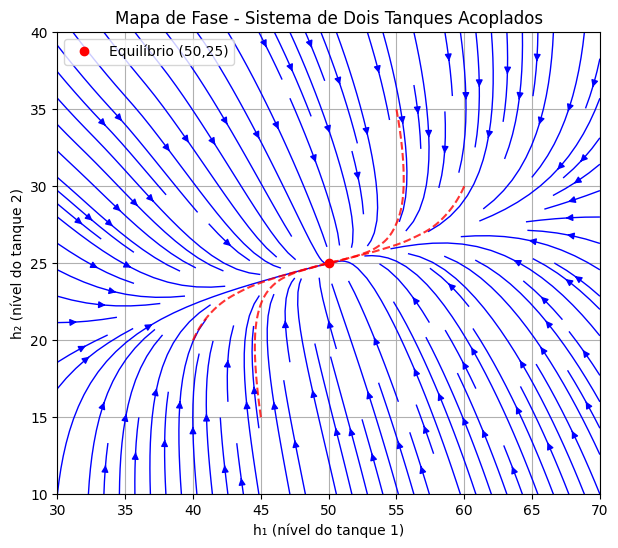

In [9]:
#@title Mapa de Fases
# --- Parâmetros e ponto de equilíbrio ---
cv = [0.1, 0.5]
a = [2.0, 4.0]
qss = [0.5, 2.0]
hss = [50.0, 25.0]

# --- Modelo não linear simplificado ---
def sistema_nl(t, X, U, params): # Added U and params as arguments
    h1, h2 = X
    q1, q2 = U # Use the input U
    # Access parameters from the params dictionary
    cv_local = params['cv']
    a_local = params['a']
    dh1 = (q1 - cv_local[0]*np.sqrt(max(0, h1 - h2))) / a_local[0] # Use cv_local and a_local
    dh2 = (q2 + cv_local[0]*np.sqrt(max(0, h1 - h2)) - cv_local[1]*np.sqrt(max(0, h2))) / a_local[1] # Use cv_local and a_local
    return [dh1, dh2]

# --- Geração do campo vetorial ---
h1_vals = np.linspace(30, 70, 25)
h2_vals = np.linspace(10, 40, 25)
H1, H2 = np.meshgrid(h1_vals, h2_vals)
U, V = np.zeros_like(H1), np.zeros_like(H2)

# Assuming a steady-state input for the phase portrait
# You might need to adjust this depending on what phase portrait you want to visualize
q1_ss, q2_ss = qss # Use steady-state inputs for the phase portrait

for i in range(H1.shape[0]):
    for j in range(H1.shape[1]):
        # Pass the steady-state input and parameters to sistema_nl for the phase portrait
        dh1, dh2 = sistema_nl(0, [H1[i,j], H2[i,j]], [q1_ss, q2_ss], {'cv': cv, 'a': a})
        U[i,j], V[i,j] = dh1, dh2

# --- Plot do campo ---
plt.figure(figsize=(7,6))
plt.streamplot(H1, H2, U, V, density=1.2, color='b', linewidth=1)
plt.plot(hss[0], hss[1], 'ro', label='Equilíbrio (50,25)')

# --- Trajetórias a partir de perturbações ---
iniciais = [
    [60, 30],
    [40, 20],
    [55, 35],
    [45, 15]
]
t = np.linspace(0, 2000, 2000)
for x0 in iniciais:
    # For the trajectories, you might want to use a different input if you are simulating a disturbance.
    # Here we use the steady-state input again to show convergence to the equilibrium point.
    sol = solve_ivp(lambda t, X: sistema_nl(t, X, [q1_ss, q2_ss], {'cv': cv, 'a': a}), [0, 2000], x0, t_eval=t)
    plt.plot(sol.y[0], sol.y[1], 'r--', alpha=0.8)

plt.title('Mapa de Fase - Sistema de Dois Tanques Acoplados')
plt.xlabel('h₁ (nível do tanque 1)')
plt.ylabel('h₂ (nível do tanque 2)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#@title Simular sistema linear
# uma aproximação matemática (linear) válida apenas perto de um ponto específico (o estado estacionário, hss e qss)
def sistema_linear(t, X, U):
    return Anum @ X + Bnum @ U

# No estado estacionario calculamos:
# Para qss = [0.5, 2.0]
# hss = [50.0, 25.0]

# Para simular o sistema linear, você deve fornecer ao solver os valores de desvio e NÃO os valores absolutos
# Variáveis de desvio
U_degrau = np.array([0.6 - qss[0], 2.0 - qss[1]]) #(0.1,0)
X0_desvio = np.array([50 - hss[0], 25 - hss[1]]) #(0,0)

print(f"Perturbação aplicada: U = {U_degrau}")
print(f"Condição inicial (desvio): X0 = {X0_desvio}")

# Simular sistema linear
t_span = [0, 1000]
t_eval = np.linspace(0, 1000, 1000)
sol_linear = solve_ivp(sistema_linear, t_span, X0_desvio,
                       args=(U_degrau,), t_eval=t_eval)

Perturbação aplicada: U = [0.1 0. ]
Condição inicial (desvio): X0 = [0. 0.]


In [11]:
#@title Simular sistema não linear

# Estados Iniciais (X0_nl): O nível absoluto inicial dos 2 tanques: np.array([50, 25]).
# Entradas (U_nl): A vazão absoluta aplicada durante a simulação: np.array([0.6, 2.0]).
# Parâmetros: As constantes físicas do modelo, cv e a.

X0_nl = np.array([50, 25])
U_nl = np.array([0.6, 2.0])
sol_nl = solve_ivp(lambda t, X: sistema_nl(t, X, U_nl, {'cv': cv, 'a': a}), # Pass parameters as a dictionary here
                   t_span, X0_nl, t_eval=t_eval)


✓ Gráfico de comparação salvo como 'comparacao_linear_nl.png'

Erro máximo h1: 0.8585 m
Erro máximo h2: 0.0347 m


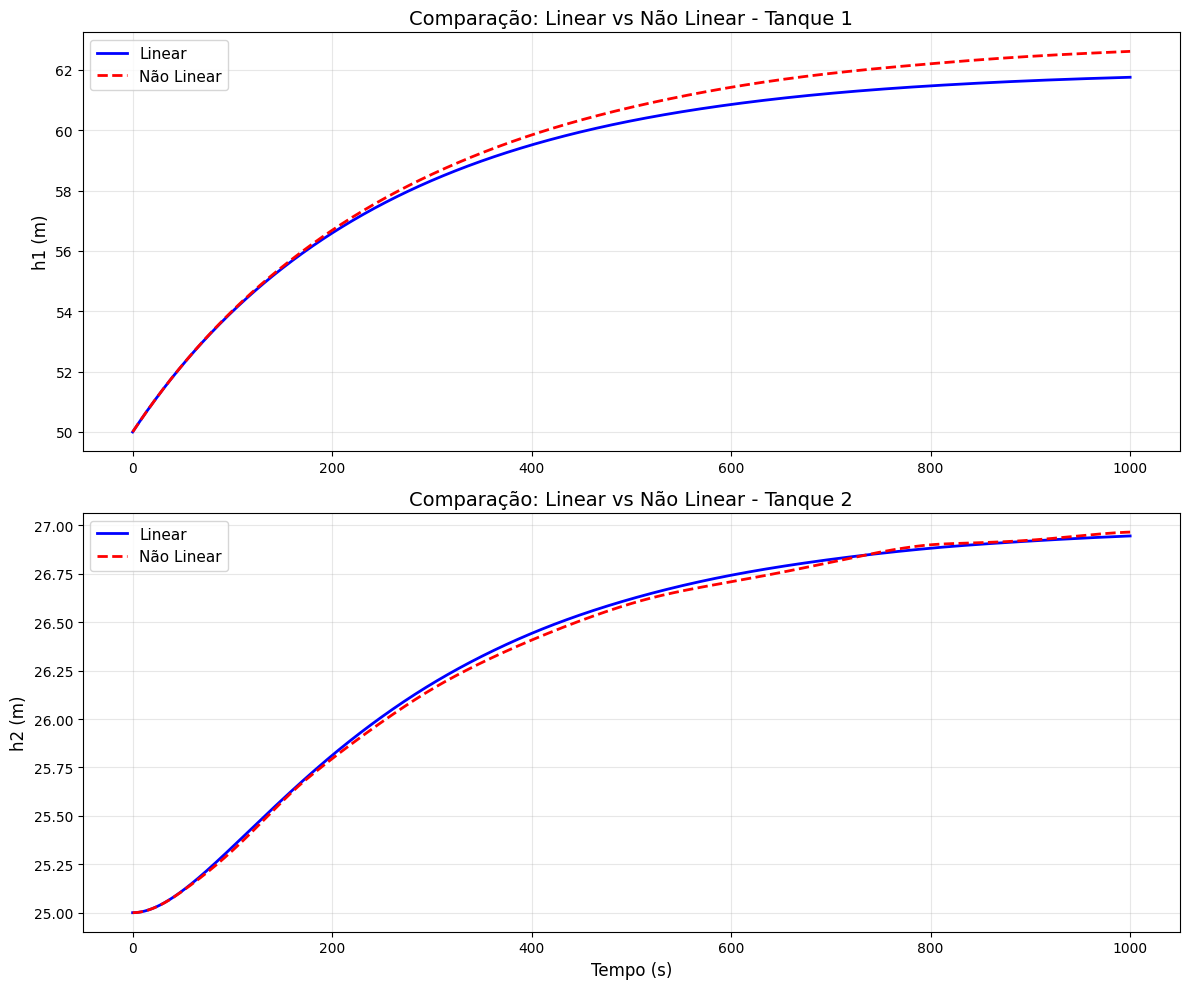

In [12]:
#@title Comparação Linear VS Não-Linear
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Na equação linear:
# sol_linear.y[0] + hss[0]
# Valor Absoluto = Valor Estacionário + Desvio
# hss[0] = valor estacionario
# sol_linear.y = desvio em tanque 1 [0]
# Essa soma converte o resultado do modelo linear (o desvio) de volta para o valor físico (o nível absoluto em metros).
# Sem essa soma, você estaria plotando apenas o desvio, e não o nível real do tanque.

# Tanque 1
ax1.plot(sol_linear.t, sol_linear.y[0] + hss[0], 'b-',
         label='Linear', linewidth=2)
ax1.plot(sol_nl.t, sol_nl.y[0], 'r--',
         label='Não Linear', linewidth=2)
ax1.set_ylabel('h1 (m)', fontsize=12)
ax1.set_title('Comparação: Linear vs Não Linear - Tanque 1', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Tanque 2
ax2.plot(sol_linear.t, sol_linear.y[1] + hss[1], 'b-',
         label='Linear', linewidth=2)
ax2.plot(sol_nl.t, sol_nl.y[1], 'r--',
         label='Não Linear', linewidth=2)
ax2.set_xlabel('Tempo (s)', fontsize=12)
ax2.set_ylabel('h2 (m)', fontsize=12)
ax2.set_title('Comparação: Linear vs Não Linear - Tanque 2', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparacao_linear_nl.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico de comparação salvo como 'comparacao_linear_nl.png'")

# Calcular erro máximo
erro_max_h1 = np.max(np.abs(sol_linear.y[0] + hss[0] - sol_nl.y[0]))
erro_max_h2 = np.max(np.abs(sol_linear.y[1] + hss[1] - sol_nl.y[1]))
print(f"\nErro máximo h1: {erro_max_h1:.4f} m")
print(f"Erro máximo h2: {erro_max_h2:.4f} m")

In [13]:
#@title Função de Transferencia
# Matriz C (assumindo que medimos todos os estados)
C = np.eye(2)
D = np.zeros((2, 2))

# Criar sistema em espaço de estados
sys_ss = ct.ss(Anum, Bnum, C, D)
print("\nSistema em espaço de estados:")
print(sys_ss)

# Obter função de transferência
sys_tf = ct.ss2tf(sys_ss)
print("\nFunção de Transferência:")
print(sys_tf)


Sistema em espaço de estados:
<StateSpace>: sys[0]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[-0.005   0.005 ]
     [ 0.0025 -0.015 ]]

B = [[0.5  0.  ]
     [0.   0.25]]

C = [[1. 0.]
     [0. 1.]]

D = [[0. 0.]
     [0. 0.]]

Função de Transferência:
<TransferFunction>: sys[1]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']

Input 1 to output 1:

      0.5 s + 0.0075
  -----------------------
  s^2 + 0.02 s + 6.25e-05

Input 1 to output 2:

   3.469e-18 s + 0.00125
  -----------------------
  s^2 + 0.02 s + 6.25e-05

Input 2 to output 1:

   6.939e-18 s + 0.00125
  -----------------------
  s^2 + 0.02 s + 6.25e-05

Input 2 to output 2:

     0.25 s + 0.00125
  -----------------------
  s^2 + 0.02 s + 6.25e-05


/usr/local/lib/python3.12/dist-packages/scipy/signal/_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


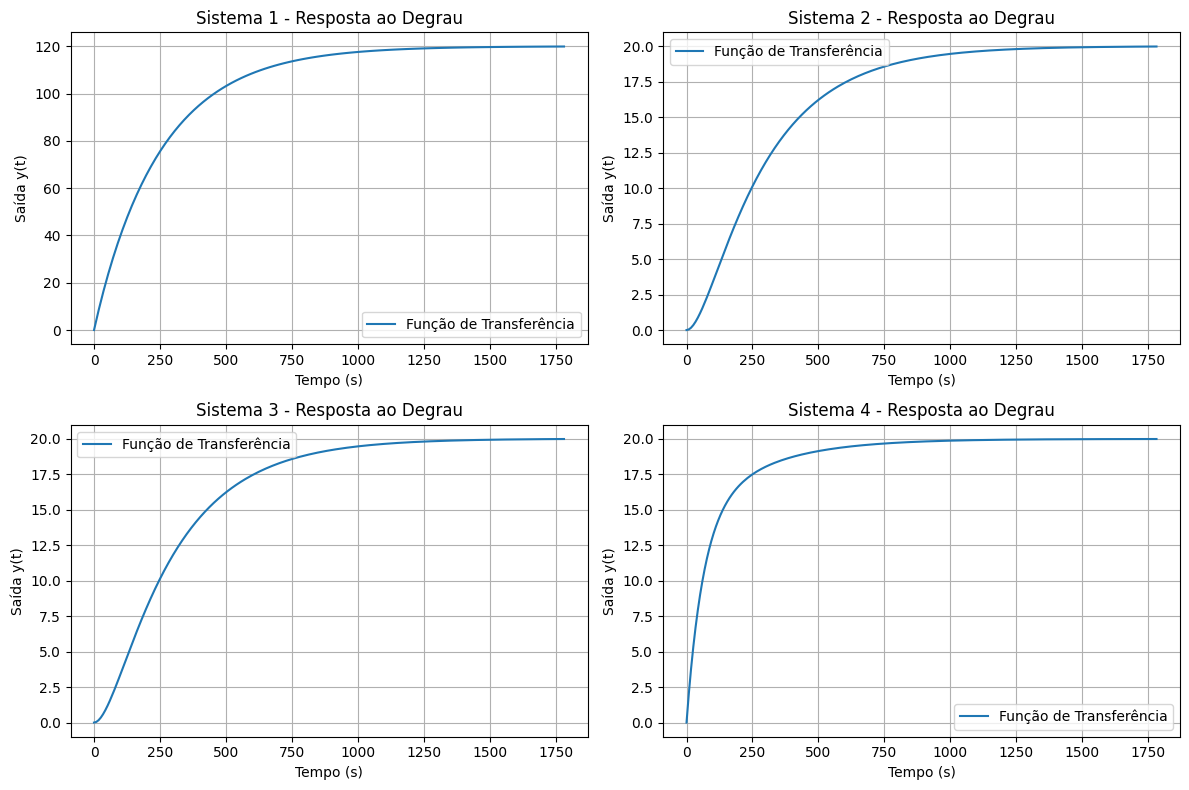

In [14]:
#@title Transformação TF para SS
# === Sistema 1 ===
num1 = [0.5, 0.0075]
den1 = [1, 0.02, 6.25e-05]
sys_tf1 = ct.tf(num1, den1)
sys_ss1 = ct.ss(sys_tf1)

# === Sistema 2 ===
num2 = [3.469e-18, 0.00125]
den2 = [1, 0.02, 6.25e-05]
sys_tf2 = ct.tf(num2, den2)
sys_ss2 = ct.ss(sys_tf2)

# === Sistema 3 ===
num3 = [6.939e-18, 0.00125]
den3 = [1, 0.02, 6.25e-05]
sys_tf3 = ct.tf(num3, den3)
sys_ss3 = ct.ss(sys_tf3)

# === Sistema 4 ===
num4 = [0.25, 0.00125]
den4 = [1, 0.02, 6.25e-05]
sys_tf4 = ct.tf(num4, den4)
sys_ss4 = ct.ss(sys_tf4)

# --- Respostas ao degrau ---
sistemas = [
    (sys_tf1, sys_ss1, 'Sistema 1'),
    (sys_tf2, sys_ss2, 'Sistema 2'),
    (sys_tf3, sys_ss3, 'Sistema 3'),
    (sys_tf4, sys_ss4, 'Sistema 4')
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

for i, (sys_tf, _, nome) in enumerate(sistemas):
    # Resposta ao degrau apenas para a função de transferência
    t_tf, y_tf = ct.step_response(sys_tf)

    axs[i].plot(t_tf, y_tf, label='Função de Transferência', color='C0')
    axs[i].set_title(f'{nome} - Resposta ao Degrau')
    axs[i].set_xlabel('Tempo (s)')
    axs[i].set_ylabel('Saída y(t)')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [15]:
# === Sistema 1 ===
num1 = [0.5, 0.0075]
den1 = [1, 0.02, 6.25e-05]
sys_tf1 = ct.tf(num1, den1)
sys_ss1 = ct.ss(sys_tf1)

# === Sistema 2 ===
num2 = [3.469e-18, 0.00125]
den2 = [1, 0.02, 6.25e-05]
sys_tf2 = ct.tf(num2, den2)
sys_ss2 = ct.ss(sys_tf2)

# === Sistema 3 ===
num3 = [6.939e-18, 0.00125]
den3 = [1, 0.02, 6.25e-05]
sys_tf3 = ct.tf(num3, den3)
sys_ss3 = ct.ss(sys_tf3)

# === Sistema 4 ===
num4 = [0.25, 0.00125]
den4 = [1, 0.02, 6.25e-05]
sys_tf4 = ct.tf(num4, den4)
sys_ss4 = ct.ss(sys_tf4)

In [16]:
#@title Formas Canônicas Controlável
from scipy import signal
import numpy as np

def mostrar_sistema(num, den, n):
    Ac, Bc, Cc, Dc = signal.tf2ss(num, den)
    print(f"\n=== SISTEMA {n} ===")
    print(f"Ac =\n{Ac}")
    print(f"Bc =\n{Bc}")
    print(f"Cc =\n{Cc}")
    print(f"Dc =\n{Dc}")

# === Sistema 1 ===
mostrar_sistema(num1, den1, 1)

# === Sistema 2 ===
mostrar_sistema(num2, den2, 2)

# === Sistema 3 ===
mostrar_sistema(num3, den3, 3)

# === Sistema 4 ===
mostrar_sistema(num4, den4, 4)


=== SISTEMA 1 ===
Ac =
[[-2.00e-02 -6.25e-05]
 [ 1.00e+00  0.00e+00]]
Bc =
[[1.]
 [0.]]
Cc =
[[0.5    0.0075]]
Dc =
[[0.]]

=== SISTEMA 2 ===
Ac =
[[-2.00e-02 -6.25e-05]
 [ 1.00e+00  0.00e+00]]
Bc =
[[1.]
 [0.]]
Cc =
[[0.      0.00125]]
Dc =
[[0.]]

=== SISTEMA 3 ===
Ac =
[[-2.00e-02 -6.25e-05]
 [ 1.00e+00  0.00e+00]]
Bc =
[[1.]
 [0.]]
Cc =
[[0.      0.00125]]
Dc =
[[0.]]

=== SISTEMA 4 ===
Ac =
[[-2.00e-02 -6.25e-05]
 [ 1.00e+00  0.00e+00]]
Bc =
[[1.]
 [0.]]
Cc =
[[0.25    0.00125]]
Dc =
[[0.]]


In [17]:
#@title Forma Canônica Observavel
from scipy import signal
import numpy as np

def mostrar_observavel(num, den, n):
    Ac, Bc, Cc, Dc = signal.tf2ss(num, den)
    Ao, Bo, Co, Do = Ac.T, Cc.T, Bc.T, Dc
    print(f"\n=== SISTEMA {n} ===")
    print(f"Ao =\n{Ao}")
    print(f"Bo =\n{Bo}")
    print(f"Co =\n{Co}")
    print(f"Do =\n{Do}")

# === Sistema 1 ===
mostrar_observavel(num1, den1, 1)

# === Sistema 2 ===
mostrar_observavel(num2, den2, 2)

# === Sistema 3 ===
mostrar_observavel(num3, den3, 3)

# === Sistema 4 ===
mostrar_observavel(num4, den4, 4)



=== SISTEMA 1 ===
Ao =
[[-2.00e-02  1.00e+00]
 [-6.25e-05  0.00e+00]]
Bo =
[[0.5   ]
 [0.0075]]
Co =
[[1. 0.]]
Do =
[[0.]]

=== SISTEMA 2 ===
Ao =
[[-2.00e-02  1.00e+00]
 [-6.25e-05  0.00e+00]]
Bo =
[[0.     ]
 [0.00125]]
Co =
[[1. 0.]]
Do =
[[0.]]

=== SISTEMA 3 ===
Ao =
[[-2.00e-02  1.00e+00]
 [-6.25e-05  0.00e+00]]
Bo =
[[0.     ]
 [0.00125]]
Co =
[[1. 0.]]
Do =
[[0.]]

=== SISTEMA 4 ===
Ao =
[[-2.00e-02  1.00e+00]
 [-6.25e-05  0.00e+00]]
Bo =
[[0.25   ]
 [0.00125]]
Co =
[[1. 0.]]
Do =
[[0.]]


In [18]:
#@title Formas Canônicas de Jordan
from scipy import signal
import numpy as np

def mostrar_jordan(num, den, n):
    Ac, Bc, Cc, Dc = signal.tf2ss(num, den)
    lamb, M = np.linalg.eig(Ac)
    Minv = np.linalg.inv(M)
    A_J = Minv @ Ac @ M
    B_J = Minv @ Bc
    C_J = Cc @ M

    print(f"\n=== SISTEMA {n} ===")
    print(f"Autovalores:\n{lamb}")
    print(f"Autovetores (M):\n{M}")
    print(f"A_J =\n{A_J}")
    print(f"B_J =\n{B_J}")
    print(f"C_J =\n{C_J}")

# Executar para cada sistema já definido anteriormente
mostrar_jordan(num1, den1, 1)
mostrar_jordan(num2, den2, 2)
mostrar_jordan(num3, den3, 3)
mostrar_jordan(num4, den4, 4)



=== SISTEMA 1 ===
Autovalores:
[-0.01612372 -0.00387628]
Autovetores (M):
[[-0.01612163  0.00387625]
 [ 0.99987004 -0.99999249]]
A_J =
[[-0.01612372  0.        ]
 [ 0.         -0.00387628]]
B_J =
[[-81.66027082]
 [-81.6502715 ]]
C_J =
[[-0.00056179 -0.00556182]]

=== SISTEMA 2 ===
Autovalores:
[-0.01612372 -0.00387628]
Autovetores (M):
[[-0.01612163  0.00387625]
 [ 0.99987004 -0.99999249]]
A_J =
[[-0.01612372  0.        ]
 [ 0.         -0.00387628]]
B_J =
[[-81.66027082]
 [-81.6502715 ]]
C_J =
[[ 0.00124984 -0.00124999]]

=== SISTEMA 3 ===
Autovalores:
[-0.01612372 -0.00387628]
Autovetores (M):
[[-0.01612163  0.00387625]
 [ 0.99987004 -0.99999249]]
A_J =
[[-0.01612372  0.        ]
 [ 0.         -0.00387628]]
B_J =
[[-81.66027082]
 [-81.6502715 ]]
C_J =
[[ 0.00124984 -0.00124999]]

=== SISTEMA 4 ===
Autovalores:
[-0.01612372 -0.00387628]
Autovetores (M):
[[-0.01612163  0.00387625]
 [ 0.99987004 -0.99999249]]
A_J =
[[-0.01612372  0.        ]
 [ 0.         -0.00387628]]
B_J =
[[-81.66027